# Calculating Q$_{net}$ for QUICCHE

In [1]:
%matplotlib inline
%pylab inline
from AirSeaFluxCode import AirSeaFluxCode  # Import the AirSeaFluxCode module
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
import cmocean.cm as cmo
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm_notebook as tqdm
from utils import *

# Define the font parameters
font_params = {
    'font.family': 'sans-serif',
    'font.weight': 'normal',
    'font.size': 24
}

# Update the font parameters using mpl.rcParams
mpl.rcParams.update(font_params)

# Adjust the tick parameters
tick_params = {
    'xtick.major.size': 8,
    'xtick.major.width': 1,
    'xtick.minor.size': 4,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.major.width': 1,
    'ytick.minor.size': 4,
    'ytick.minor.width': 1
}

# Update the tick parameters using mpl.rcParams
mpl.rcParams.update(tick_params)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Ship data, 10 minute
ship = xr.open_dataset('/home/jedholm/Validating_Sailbuoy/data/ship_met_quicche_10min_corrected.nc') 

In [3]:
# Convert ship data into NumPy arrays
lat  = np.asarray(ship["LA"])               # Latitude
spd  = np.asarray(ship["TW"])               # Wind speed
t    = np.asarray(ship["RT"])               # Air temperature
sst  = np.asarray(ship["TT"])               # Sea surface temperature
rh   = np.asarray(ship["RH"])               # Relative humidity
SW   = np.asarray(ship["SW"])               # Shortwave radiation
DLW  = np.asarray(ship["LW"])               # Downwelling longwave radiation

# Measurement height for the wind, temperature, and humidity sensors
hin  = 17

# Calculate the Stefan-Boltzmann constant
sigma = 5.67 * 1e-8

# Calculate the upwelling longwave radiation, calculated from Stefan-Boltzmanns law
ULW  = np.asarray(sigma*(ship['TT']+273.15)**4)

LW   = np.asarray(DLW - ULW)

In [4]:
outputs = ["tau", "sensible", "latent", "monob", "cd", "cd10n",
           "ct", "ct10n", "cq", "cq10n", "tsrv", "tsr", "qsr",
           "usr", "psim", "psit", "psiq", "psim_ref", "psit_ref",
           "psiq_ref", "u10n", "t10n", "q10n", "zo", "zot", "zoq",
           "uref", "tref", "qref",'Rs','Rnl', "qair", "qsea", "Rb", "rh",
           "rho", "cp", "lv", "theta", "itera"]

In [5]:
# Create a new dataset for the current method and skin
ds = xr.Dataset()

# Add a 'time' variable to the dataset and populate it with time data from the 'ship' dataset
ds['time'] = ship.time

# Call the AirSeaFluxCode function to calculate air-sea fluxes for the current method and skin
# The result is stored in the 'df' DataFrame
df = AirSeaFluxCode(spd, t, sst, 'bulk', hum=["rh", rh], meth='C35', lat=lat, Rl=DLW, Rs=SW, hin=hin, hout=10, out_var=outputs, cskin=1, skin='C35')

# Loop through the desired output variables and add them to the dataset
for var in outputs:
    # Assign the variable from the 'df' DataFrame to the dataset, and specify that it varies with time
    ds[var] = ('time',), df[var]

# Add a new dimension 'method' to the dataset, indicating the current method
ds.coords['method'] = 'C35'

In [6]:
# Define the attributes
attributes = {
    'momentum_flux': 'Nm^-2',
    'sensible_heat': 'Wm^-2',
    'latent_heat': 'Wm^-2',
    'Monin_Obhukov_length': 'm',
    'drag_coefficient': 'cd',
    'neutral_drag_coefficient_at_10m': 'cd10n',
    'heat_exchange_coefficient': 'ct',
    'neutral_heat_exchange_coefficient_at_10m': 'ct10n',
    'moisture_exchange_coefficient': 'cq',
    'neutral_moisture_exchange_coefficient_at_10m': 'cq10n',
    'virtual_temperature_scaling_parameter': 'tsrv',
    'temperature_scaling_parameter': 'tsr',
    'specific_humidity_scaling_parameter': 'qsr',
    'wind_speed_scaling_parameter': 'usr',
    # 'wind_speed_scaling_parameter_including_effect_of_gustiness': 'usr_gust',
    # 'wind_speed_scaling_parameter_effect_of_gustiness_removed': 'usr_nogust',
    # 'gust_wind_speed': 'ug',
    # 'gustiness_factor': 'GustFact',
    'momentum_stability_function': 'psim',
    'heat_stability_function': 'psit',
    'moisture_stability_function': 'psiq',
    'momentum_stability_function_at_reference_height': 'psim_ref',
    'heat_stability_function_at_reference_height': 'psit_ref',
    'moisture_stability_function_at_reference_height': 'psiq_ref',
    '10m_neutral_wind_speed': 'u10n',
    '10m_neutral_temperature': 't10n',
    '10m_neutral_specific_humidity': 'q10n',
    'surface_momentum_roughness_length': 'zo',
    'heat_roughness_length': 'zot',
    'moisture_roughness_length': 'zoq',
    'wind_speed_at_reference_height': 'uref',
    'temperature_at_reference_height': 'tref',
    'specific_humidity_at_reference_height': 'qref',
    # 'cool_skin_temperature_depression': 'dter',
    # 'cool_skin_humidity_depression': 'dqer',
    # 'warm_layer_correction': 'dtwl',
    # 'thickness_of_the_viscous_layer': 'tkt',
    # 'downward_longwave_radiation': 'Rl',
    'downward_shortwave_radiation': 'Rs',
    'downward_net_longwave_radiation': 'Rnl',
    'specific_humidity_of_air': 'qair',
    'specific_humidity_at_sea_surface': 'qsea',
    'Bulk_Richardson_number': 'Rb',
    'relative_humidity': 'rh',
    'air_density': 'rho',
    'specific_heat_of_moist_air': 'cp',
    'latent_heat_of_vaporisation': 'lv',
    'air_potential_temperature': 'theta',
    'number_of_iterations_until_convergence': None,
    # 'flag': None
}

# Add the attributes to the dataset
i = 0
for var_name, unit in attributes.items():
    
    ds[list(ds.keys())[i]].attrs['unit'] = unit
    ds[list(ds.keys())[i]].attrs['name'] = var_name
    i+=1

# You can set 'None' for variables that don't have units.

ds = ds.rename({'Rs':'shortwave', 'Rnl':'longwave'})

In [32]:
ds['qnet'] = ds['shortwave'] + ds['longwave'] + ds['sensible'] + ds['latent']
ds = ds.where(np.abs(ds['qnet']) < 1000)

In [35]:
def plot_ds(ds, variables, title):
    """
    Plot time series data from a dataset 'ds' for specified 'variables'.

    Parameters:
    - ds (xarray.Dataset): The dataset containing the time series data.
    - variables (list): A list of variable names to be plotted.

    Example:
    plot_ds(ds, ['sensible', 'latent', 'shortwave', 'longwave'])
    """
    # Define a list of colors and line styles for the variables
    colors = ['0', '0', '0.75', '0.5']
    line_styles = ['--', '-', '-', '-']

    # Create a plot with one set of axes (a figure) with specific properties
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30, 4 * 2))

    # Plot the 'qnet' data series
    ax.plot(ds.time.values, ds['qnet'].rolling(time=7, center=True).mean('time'),
            zorder=3, label=r"Q$_{net}$", lw=2, c='C1')

    # Create a loop to plot additional data series based on 'variables' list
    for var, color, line_style in zip(variables, colors, line_styles):
        # Plot each data series in the loop
        ax.plot(ds.time.values, ds[var].rolling(time=7, center=True).mean('time'),
                zorder=2, label=f"{var.capitalize()}", lw=1.5, c=color, ls=line_style)

    # Add a horizontal dashed line at y=0
    ax.axhline(0, lw=2, ls='--', c='0.75')
    
    # Call a function 'add_port_call' with some arguments
    add_port_call(ax, 'r', ylim=(-600, 1000))

    # Add a legend to the plot to explain what each line represents
    ax.legend(ncol=2, fontsize='small')

    # Set labels and limits for the y-axis and remove the x-axis label
    ax.set(ylabel=r"(W m$^{-2}$)", xlabel='', ylim=(-600, 1000), title=f"Heat fluxes QUICCHE, {title}")


    # Call a function 'fix_xticks' with 'ax' and 'ds' as arguments
    fix_xticks([ax], ds)

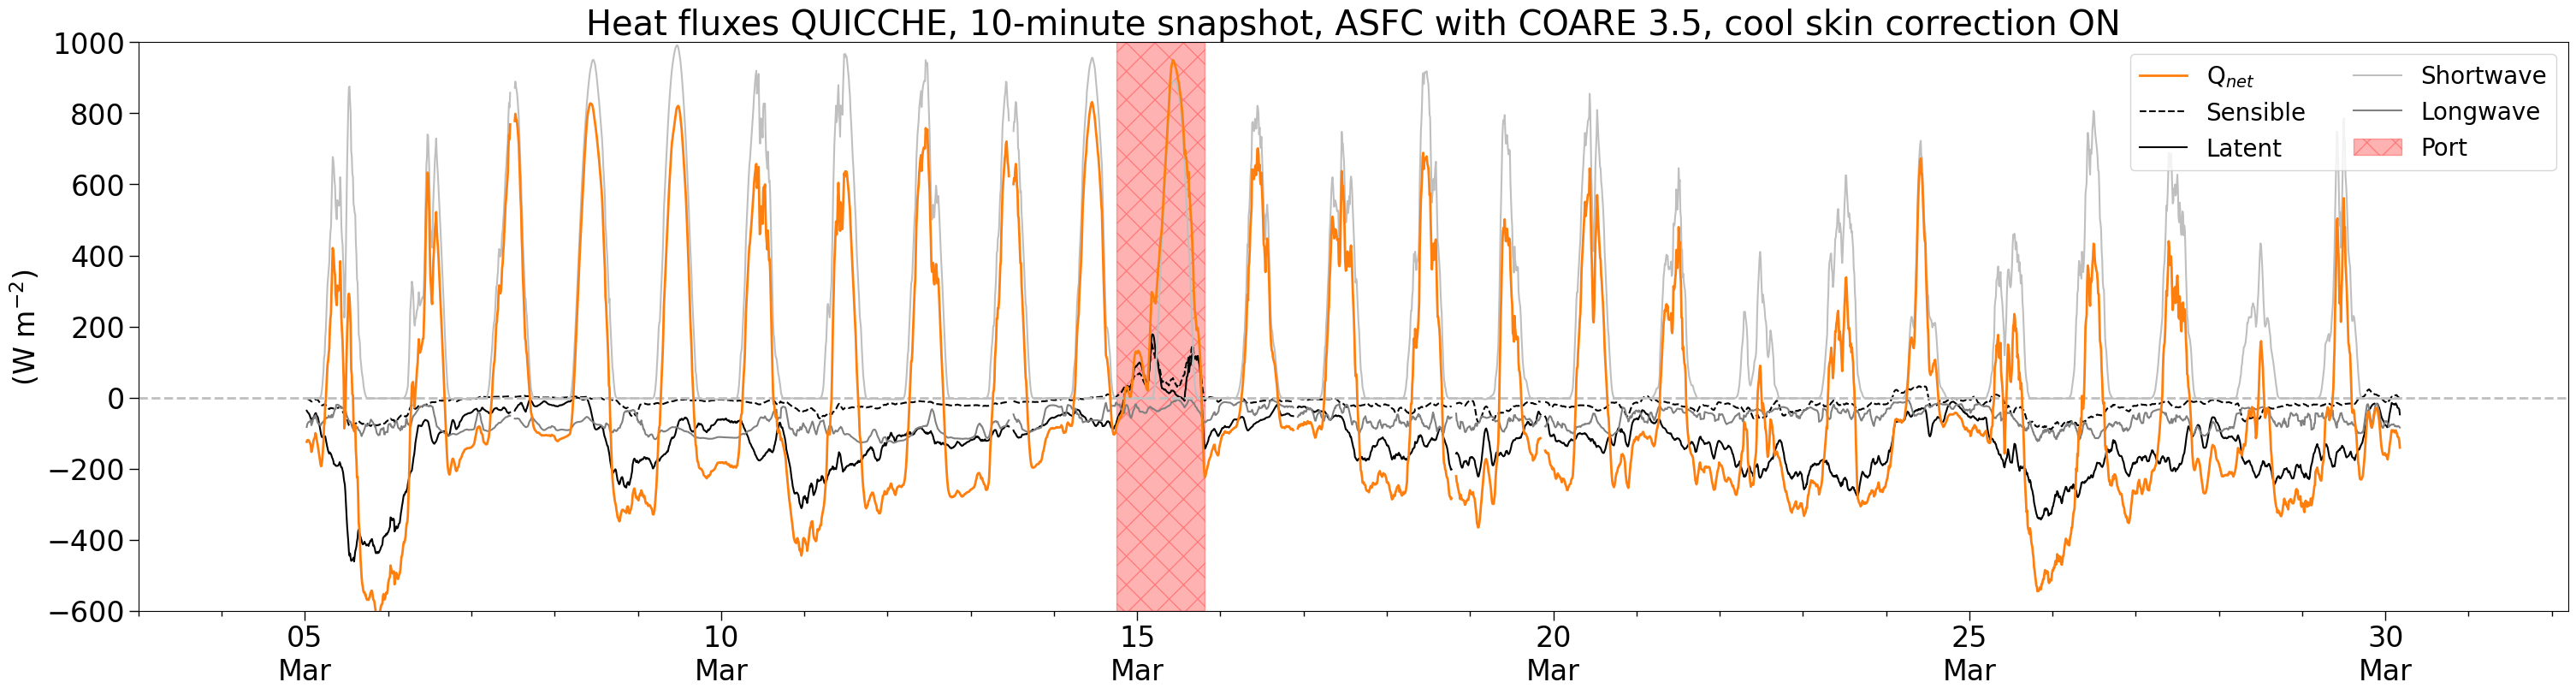

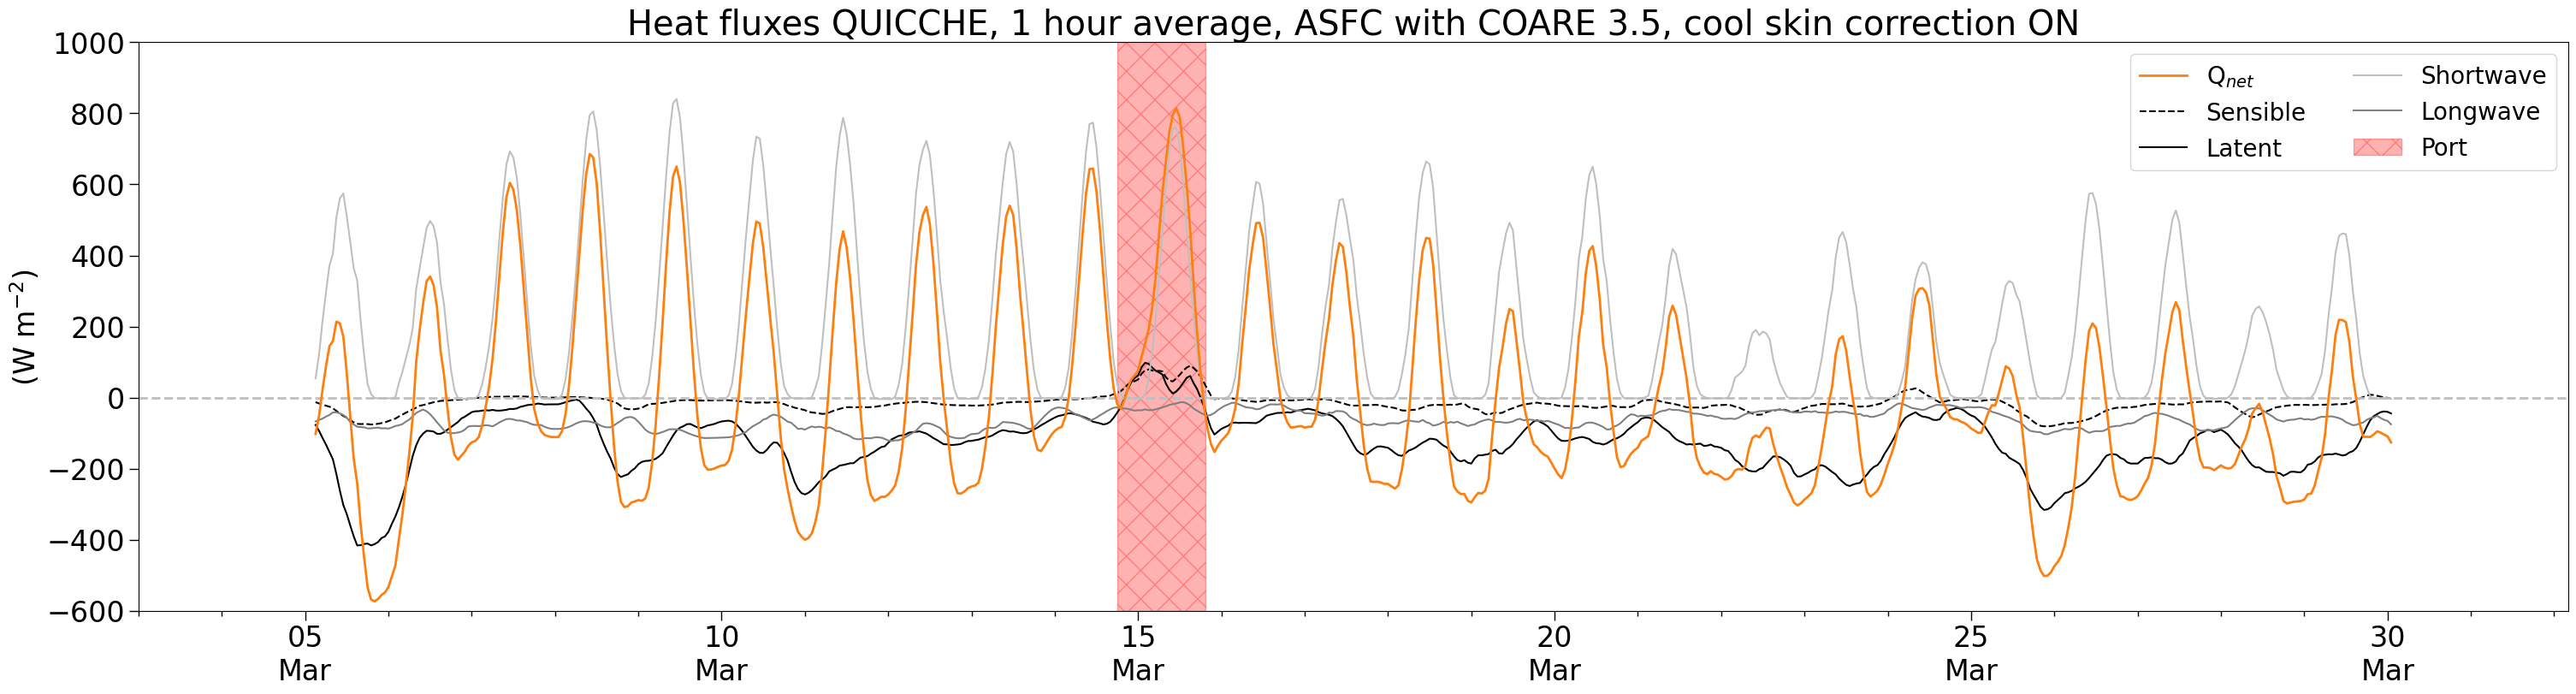

In [39]:
# Example usage:
plot_ds(ds, ['sensible', 'latent', 'shortwave', 'longwave'], title='10-minute snapshot, ASFC with COARE 3.5, cool skin correction ON')
plot_ds(ds.resample(time='1H').mean('time'), ['sensible', 'latent', 'shortwave', 'longwave'], title='1 hour average, ASFC with COARE 3.5, cool skin correction ON')